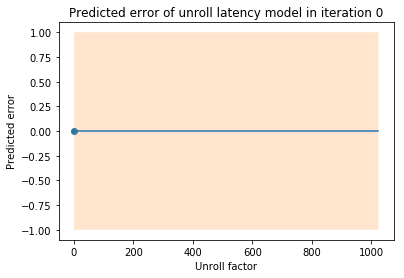

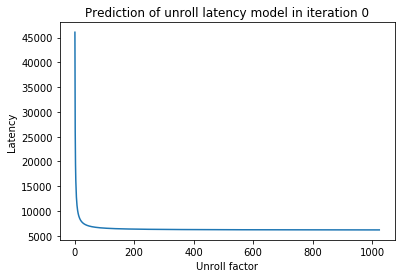

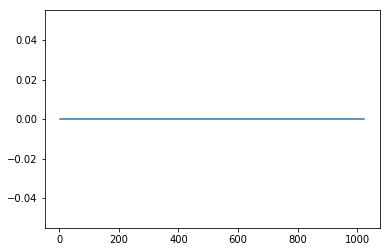

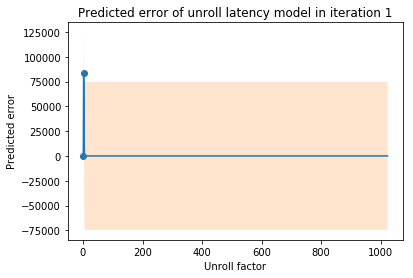

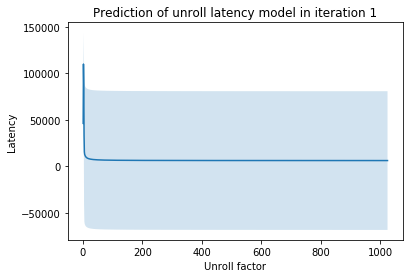

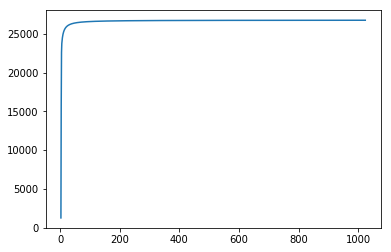

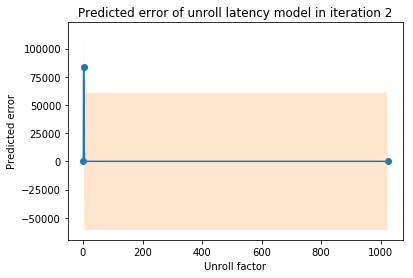

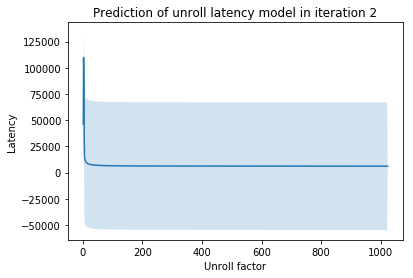

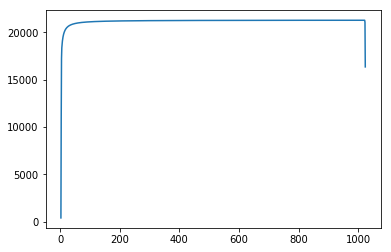

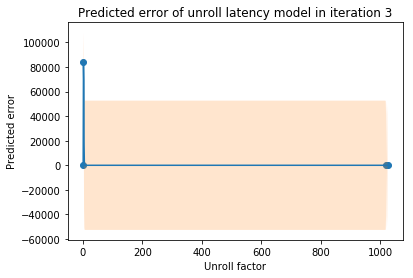

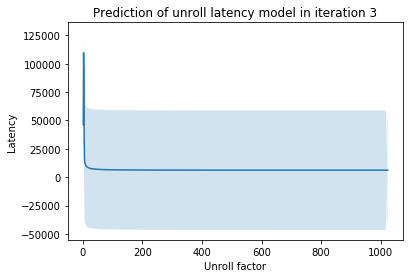

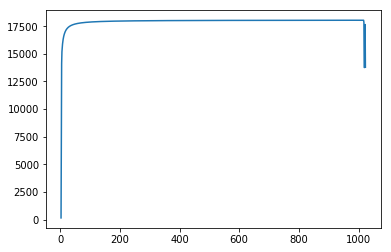

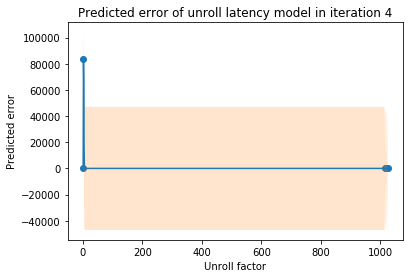

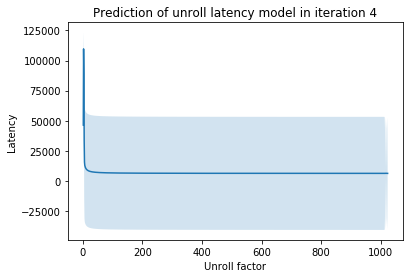

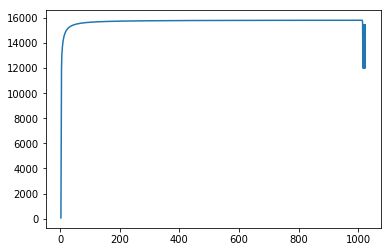

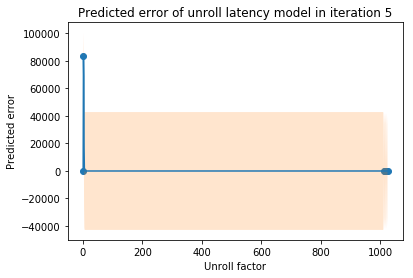

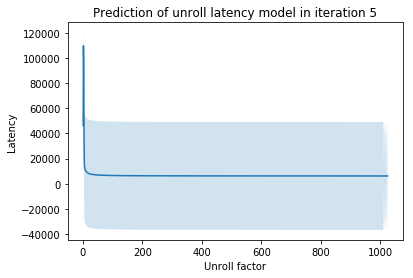

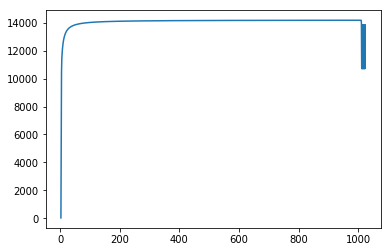

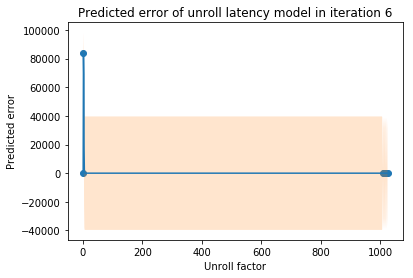

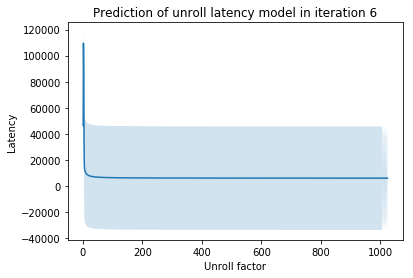

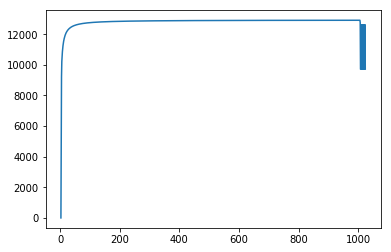

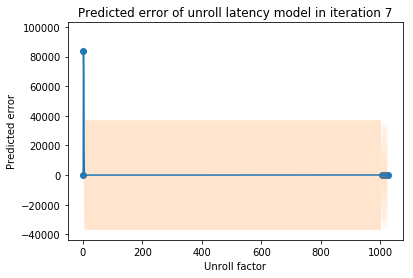

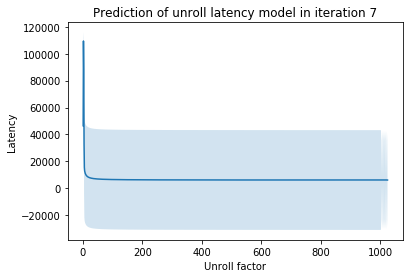

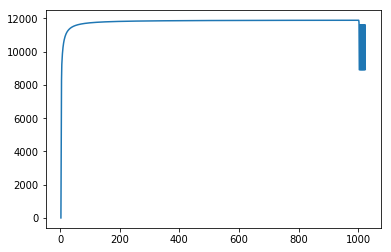

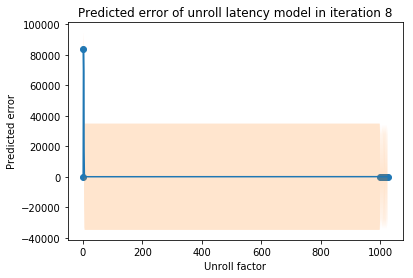

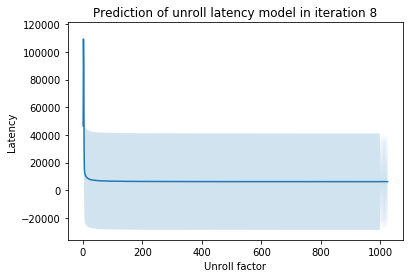

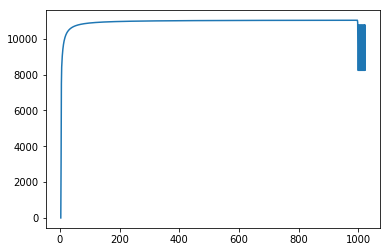

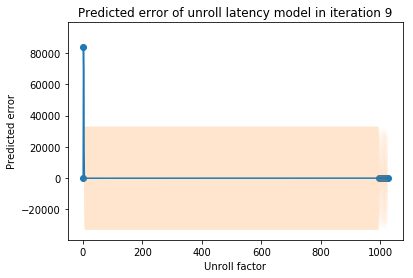

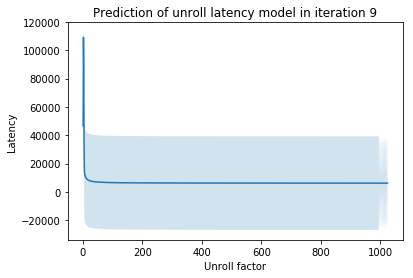

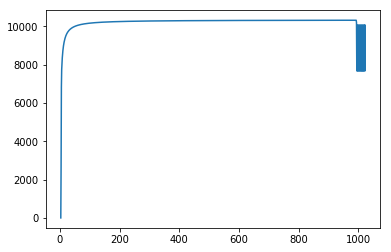

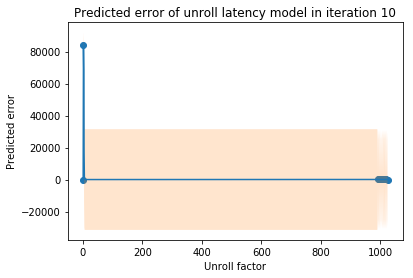

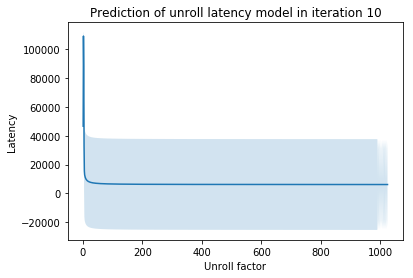

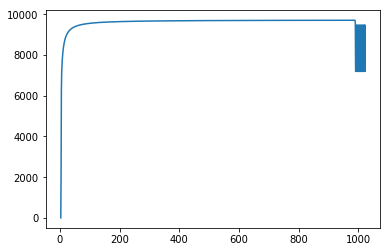

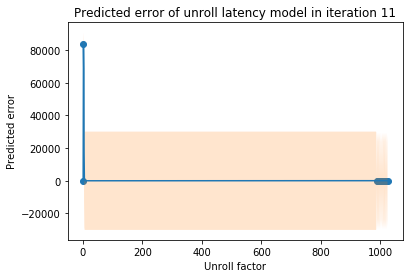

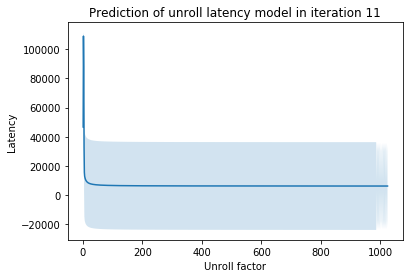

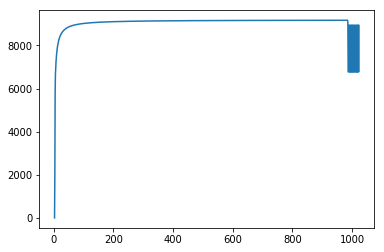

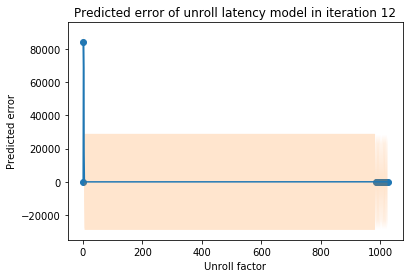

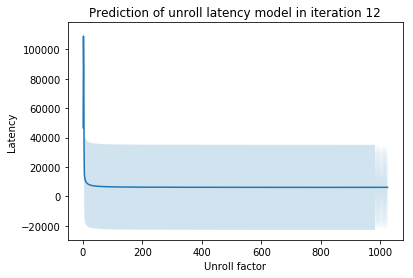

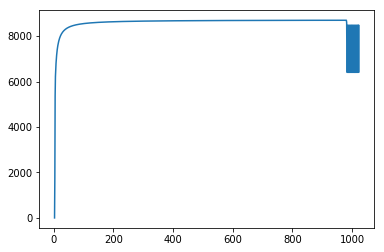

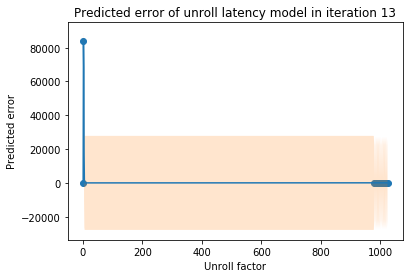

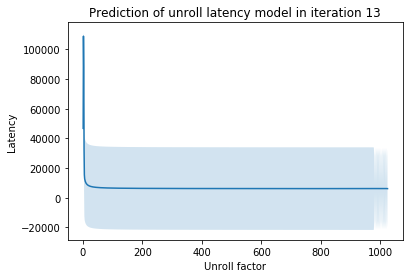

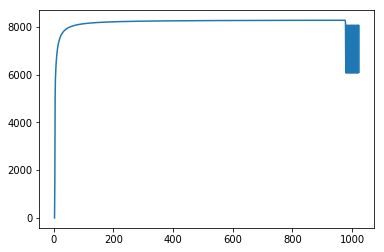

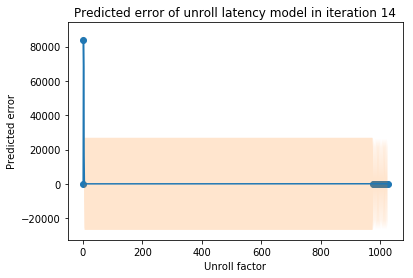

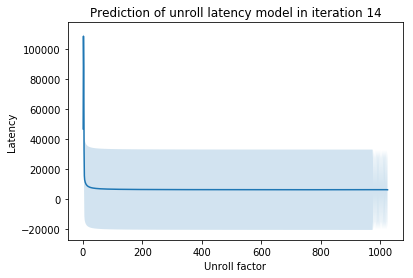

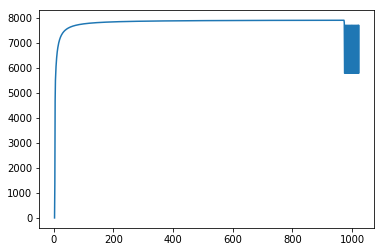

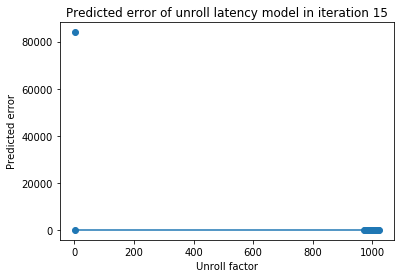

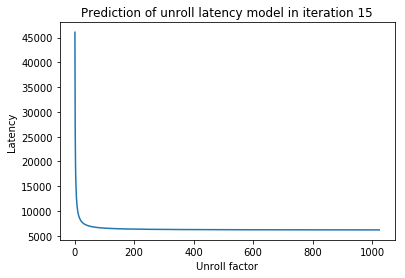

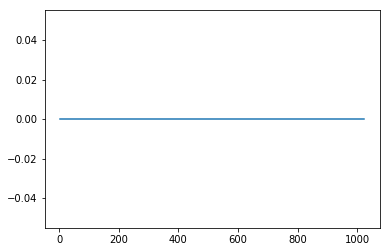

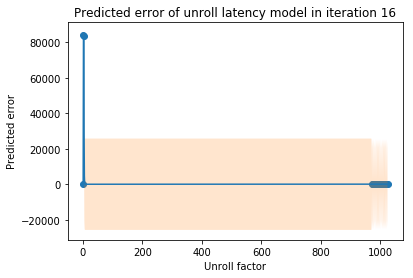

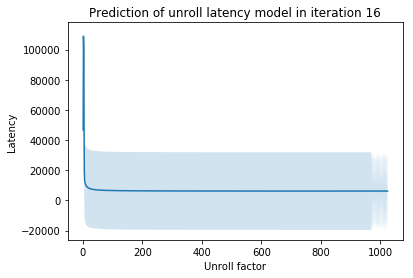

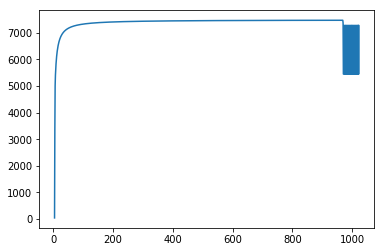

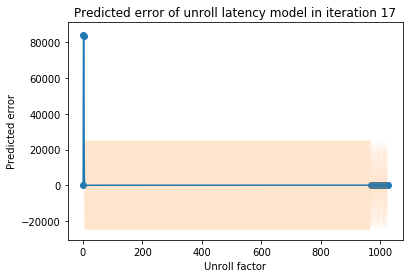

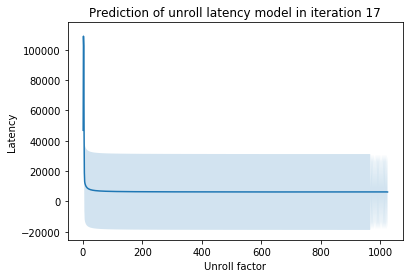

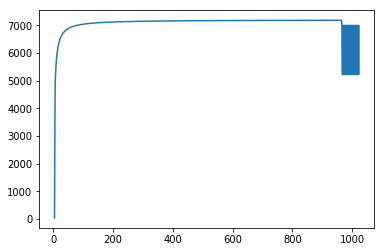

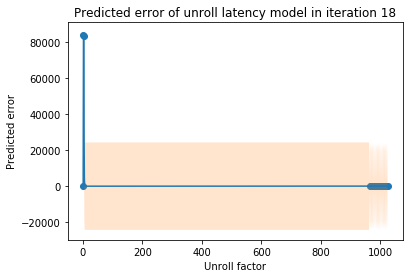

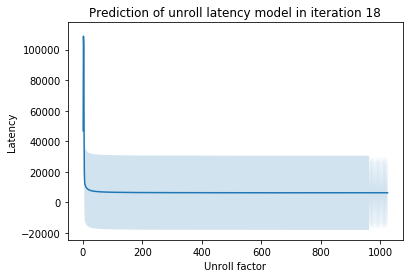

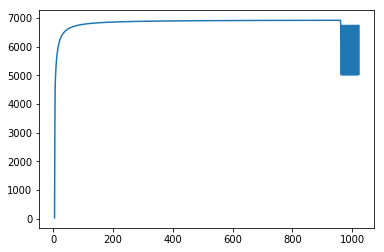

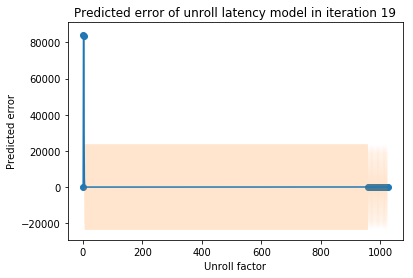

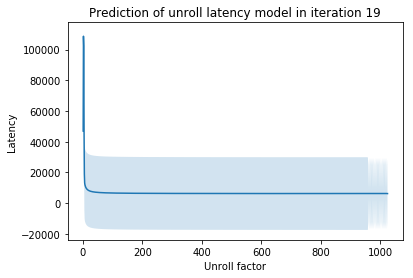

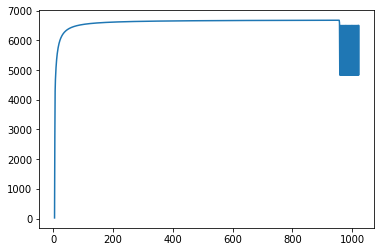

In [18]:
import glob, numpy, os, random, re, warnings
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

test_dir = '/proj/xsjhdstaff5/hansg/Tests/Unroll_toy/20190724_exhaustive'
output_dirs = sorted(glob.glob(test_dir + '/Output/Output/*/'))

max_factor = 1024

factors = range(1, max_factor + 1)
latencies = []
for output_dir in output_dirs:
    try:
        with open(output_dir + 'Latency.txt', 'r') as input_file:
            text = input_file.read()
        latency = float(text)
    except:
        latency = 1e10
    latencies.append(latency)
    if len(latencies) == max_factor:
        break

def simple_model(factor):
    return 3072 + 39936 / factor + 3072 + 3

def compute_expec_impr(gaussian_process, factor, best_result):
    error, std_dev = gaussian_process.predict([[factor]], return_std = True)
    pred = simple_model(factor)
    mean = pred + error
    if std_dev != 0:
        diff = best_result - mean
        Z = diff / std_dev
        expec_impr = diff * norm.cdf(Z) + std_dev * norm.pdf(Z)
    else:
        expec_impr = 0.0
    return expec_impr

def select_design(X, Y, gaussian_process):
    best_result = min(Y)
    expec_imprs = []
    subset = sorted(list(set(factors) - set(X)))
    for factor in subset:
        expec_imprs.append(compute_expec_impr(gaussian_process, factor, best_result))
    plt.plot(subset, expec_imprs)
    plt.show()
    return subset[expec_imprs.index(max(expec_imprs))]

kernel = ConstantKernel(1.0, [1e-10, 1e20]) * RBF(1.0, [(1.0, max_factor - 1.0)])
gaussian_process = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 10, alpha = 1)

X = [1]
Y = [0]
for i in range(20):
    errors = gaussian_process.predict([[factor] for factor in factors], return_std = True)

    plt.scatter(X, Y)
    plt.plot(factors, errors[0])
    plt.fill_between(factors, errors[0] - errors[1], errors[0] + errors[1], alpha = 0.2)
    plt.title('Predicted error of unroll latency model in iteration ' + str(i))
    plt.xlabel('Unroll factor')
    plt.ylabel('Predicted error')
    plt.show()
    
    preds = [simple_model(factor) for factor in factors]
    mean = [errors[0][i] + preds[i] for i in range(max_factor)]
    
    plt.plot(factors, mean)
    plt.fill_between(factors, mean - errors[1], mean + errors[1], alpha = 0.2)
    plt.title('Prediction of unroll latency model in iteration ' + str(i))
    plt.xlabel('Unroll factor')
    plt.ylabel('Latency')
    plt.show()
    
    factor = select_design(X, Y, gaussian_process)
    error = latencies[factor - 1] - simple_model(factor)
    X.append(factor)
    Y.append(error)

    dyn_range = (max(Y) - min(Y)) ** 2
    kernel = ConstantKernel(1.0, [1e-10, dyn_range]) * RBF(1.0, [(1.0, max_factor - 1.0)])
    gaussian_process = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 10, alpha = dyn_range / 1e3)
    gaussian_process.fit([[value] for value in X], Y)